<a href="https://www.kaggle.com/code/ilaydauan/aygazg-r-nt-i-leme?scriptVersionId=213739205" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-images.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/trainclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-continuous.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-binary.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-attributes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix.png
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicates.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/testclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/classes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10525.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10049.txt
/kaggle/input/animals-with-attributes-2/Animals_wi


# **1- Gerekli Kütüphanelerin Yüklenmesi**cv2 → Görüntü işlemeImageDataGenerator → Veri artırımıSequential → Model oluşturmak için


In [2]:

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# **2- Veri Setinin Hazırlanması :**

# *2.1 Veri Setinin Filtrelenmesi*

In [3]:
# Veri seti klasörlerinin yolları
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"  # Veri seti klasörünün yolu
target_dir = "FilteredImages"  # Filtrelenmiş verilerin kaydedileceği yol

# Kullanılacak sınıflar
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650

# Filtreleme
os.makedirs(target_dir, exist_ok=True)
for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(target_dir, class_name)
    os.makedirs(target_path, exist_ok=True)
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= images_per_class:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            cv2.imwrite(os.path.join(target_path, file_name), cv2.imread(full_file_name))
print("Veri seti hazırlandı ve dengelendi.")


Veri seti hazırlandı ve dengelendi.


# *2.2 - Boyutlandırma ve Normalizasyon*

In [4]:
# Görüntülerin işlenmesi (128x128 boyutlandırma ve normalizasyon)
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

data_dir = target_dir
X, y = load_and_process_images(data_dir)
print(f"Veri kümesi boyutu: {X.shape}")


Veri kümesi boyutu: (6500, 128, 128, 3)


# **2.3 Veriyi Eğitim ve Test Seti Olarak Ayırma**

In [5]:
# Etiketlerin dönüştürülmesi
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Veriyi bölme (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")

Eğitim veri boyutu: (4550, 128, 128, 3), Test veri boyutu: (1950, 128, 128, 3)


# **3- Veri Setinin Ayrılması ve Veri Artırımı**

# **3.1- Veri Artırımı**

In [6]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# **4- CNN Modelinin Oluşturulması ve Eğitilmesi**

In [7]:

# CNN Modeli
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(128, 128, 3)),  # Burada Input kullanılıyor
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Veri artırma (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)



# Eğitim ve doğrulama jeneratörleri
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# steps_per_epoch ve validation_steps hesaplama
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_test) // 32

# Modeli eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 544ms/step - accuracy: 0.2382 - loss: 4.0183 - val_accuracy: 0.4266 - val_loss: 1.6723
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.5312 - loss: 1.5101 - val_accuracy: 0.3667 - val_loss: 1.8664
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.4706 - loss: 1.5749 - val_accuracy: 0.4703 - val_loss: 1.5943
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.4375 - loss: 1.6230 - val_accuracy: 0.5333 - val_loss: 1.5957
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.5206 - loss: 1.4541 - val_accuracy: 0.5083 - val_loss: 1.4827
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.3125 - loss: 1.8930 - val_accuracy: 0.5000 - val_loss: 1.5410
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 516ms/step - accuracy: 0.5462 - loss: 1.3867 - val_accuracy: 0.4958 - val_loss: 1.4541
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.5625 - loss: 1.2463 - val_accuracy: 0.5000 - val_loss: 1.2357
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.5452 - loss: 1.3507 - val_accuracy: 0.5333 - val_loss: 1.4064
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.5312 - loss: 1.3404 - val_ac

# **5 -Model Performansını Görselleştirme**

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 492ms/step - accuracy: 0.6057 - loss: 1.1597 - val_accuracy: 0.5769 - val_loss: 1.2936
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 512ms/step - accuracy: 0.6109 - loss: 1.1547 - val_accuracy: 0.5862 - val_loss: 1.2891
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 486ms/step - accuracy: 0.6056 - loss: 1.1403 - val_accuracy: 0.5472 - val_loss: 1.3392
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 478ms/step - accuracy: 0.6128 - loss: 1.1206 - val_accuracy: 0.5703 - val_loss: 1.3082
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.6169 - loss: 1.0943 - val_accuracy: 0.5590 - val_loss: 1.4576
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 636ms/step - accuracy: 0.6159 - loss: 1.1064 - val_accuracy: 0.5733 - val_loss: 1.3346
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 490ms/step - accuracy: 0.6216 - loss: 1.1103 - val_accuracy: 0.5985 - val_loss: 1.2575
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.6299 - loss: 1

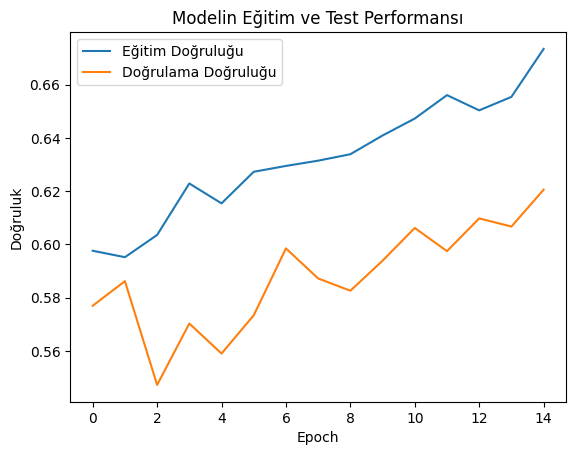

In [8]:
# Modeli eğitme
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=15)

# Eğitim ve doğrulama sonuçlarının grafiği
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title("Modelin Eğitim ve Test Performansı")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.show()


# **6- Farklı Işık Koşullarıyla Test Etme**

In [9]:
# Manipülasyon fonksiyonu
def get_manipulated_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=0.8, beta=30)  # Örnek manipülasyon
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

X_test_manipulated = get_manipulated_images(X_test)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1043 - loss: 289.1493
Manipüle Edilmiş Test Doğruluğu: 10.00%


# **7- Manipüle Edilmiş Test Seti ile Modeli Test Etme**

In [10]:
# Manipüle edilmiş test seti üzerinde test etme
test_loss, test_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Seti Doğruluk: {test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.1043 - loss: 289.1493
Manipüle Edilmiş Test Seti Doğruluk: 0.10000000149011612


# **8- Renk Sabitliği Algoritması Uygulama ve Test Etme**

In [11]:
# Gray World algoritması (örnek)
def gray_world(images):
    wb_images = []
    for img in images:
        avg_b = np.mean(img[:, :, 0])
        avg_g = np.mean(img[:, :, 1])
        avg_r = np.mean(img[:, :, 2])
        avg_gray = (avg_b + avg_g + avg_r) / 3
        img[:, :, 0] = img[:, :, 0] * (avg_gray / avg_b)
        img[:, :, 1] = img[:, :, 1] * (avg_gray / avg_g)
        img[:, :, 2] = img[:, :, 2] * (avg_gray / avg_r)
        wb_images.append(img)
    return np.array(wb_images)

# Manipüle edilmiş test verisine Gray World algoritmasını uygulama
X_test_corrected = gray_world(X_test_manipulated)

# Modeli renk sabitliği uygulanmış test setiyle değerlendirme
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {corrected_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.1043 - loss: 298.9558
Renk Sabitliği Uygulanmış Test Doğruluğu: 10.00%


# **Model Test Edilmesi:**

In [12]:
test_loss, test_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluk: {test_accuracy}")



61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.1043 - loss: 298.9558
Renk Sabitliği Uygulanmış Test Seti Doğruluk: 0.10000000149011612


In [13]:
# Orijinal test setinde doğruluk hesaplama
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")

# Manipüle edilmiş test setinde doğruluk hesaplama
X_test_manipulated = get_manipulated_images(X_test)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test, verbose=0)
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {manipulated_accuracy * 100:.2f}%")

# Renk sabitliği uygulanmış test setinde doğruluk hesaplama
X_test_corrected = gray_world(X_test_manipulated)
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test, verbose=0)
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluğu: {corrected_accuracy * 100:.2f}%")


Orijinal Test Seti Doğruluğu: 62.05%
Manipüle Edilmiş Test Seti Doğruluğu: 10.00%
Renk Sabitliği Uygulanmış Test Seti Doğruluğu: 10.00%
